# CIFAR-10 Image Classifier

### Waterloo Aerial Robotics Group Computer Vision Onboarding

Mckale Chung

This is a image classifying model with a 70% accuracy rate, trained on the CIFAR - 10 data set. 

In [120]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix
import torch
from torch import nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision
from torch.utils.data import random_split
import torch.nn.functional as F



I first defined a composition of the pytorch built-in ToTensor and Normalize function. 

I then loaded the training and testing data sets from PyTorch, and created data loaders for these sets. 

In [122]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

training_data_raw = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testing_data = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


#Taking 2000 images for validation
val_size = 2000
#book_size = 2000  for testing the model, just using a smaller batch for speed
#The rest of the images are for standard training
train_size = len(training_data_raw) - val_size 



#splitting the raw 50000 training data into a training and validation data set
training_data, val_data = random_split(training_data_raw, [train_size, val_size])
#training_data, book_data = random_split(training_data, [new_train_size, book_size])


#confirming a proper split
print(f"Length of Training Data : {len(training_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of tset Data : {len(testing_data)}")


#Making loaders for all data

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
#book_loader = DataLoader(book_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(testing_data, batch_size = batch_size, shuffle = True, num_workers = 2)




Files already downloaded and verified
Files already downloaded and verified
Length of Training Data : 48000
Length of Validation Data : 2000
Length of tset Data : 10000


To confirm that the data loaded in, I first created a seperate dictionary with the 10 distinct classes. I can now reference the index of these to get a label name. 

In [123]:
classes = training_data_raw.classes
print(classes)
print(type(training_data_raw))


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
<class 'torchvision.datasets.cifar.CIFAR10'>


### Showing the Data

The following code shows a set of 8 images, and their corresponding labels


tensor([3, 9, 4, 2, 2, 3, 0, 6])


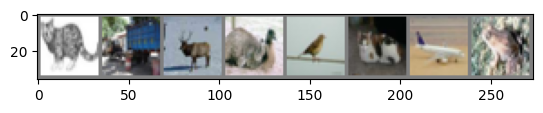

cat
truck
deer
bird
bird
cat
airplane
frog


In [124]:
def imshow(img):
    #unnormalizing the images
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(labels)

#showing the images and the labels in the same order
imshow(torchvision.utils.make_grid(images))
for img_num in range(batch_size):
    print(classes[labels[img_num]])

plt.show()

In [125]:
#using a cross entropy loss function and setting an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [126]:

def accuracy(outputs, labels):
    _, prediction = torch.max(outputs,1)
    return torch.tensor(torch.sum(prediction == labels).item() / len(prediction))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

class Net(nn.Module):

    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
        nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(4096,120),
        nn.ReLU(),
        nn.Linear(120, 80),
        nn.ReLU(),
        nn.Linear(80,10)
        )
    
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch 
        outputs = self(images) 
        loss = criterion(outputs, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        outputs = self(images) 
        
        # Generate predictions
        val_loss = criterion(outputs, labels) 
        acc = accuracy(outputs, labels)          
        return {'val_loss': val_loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = []
        batch_accuracies = []
        
        for output in outputs:
            batch_losses.append(output['val_loss'])
            batch_accuracies.append(output['val_acc'])

        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        epoch_acc = torch.stack(batch_accuracies).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        current_loss = result["train_loss"]
        current_val_acc =  result["val_acc"]
        print(f'Epoch [{epoch + 1}], training loss: {result["train_loss"]:.3f}, validation loss: {result["val_loss"]:.4f}, validation accuracy: {result["val_acc"]:.4f}')


net = Net()

In [127]:


losses = {}
val_losses = {}
  
def fit(epochs, lr, model, training_loader, validation_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in training_loader:

            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, validation_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [129]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, net, train_loader, val_loader, opt_func)

Epoch [1], training loss: 1.348, validation loss: 1.1062, validation accuracy: 0.6130
Epoch [2], training loss: 0.971, validation loss: 0.8786, validation accuracy: 0.6880
Epoch [3], training loss: 0.822, validation loss: 0.8103, validation accuracy: 0.7255
Epoch [4], training loss: 0.735, validation loss: 0.8087, validation accuracy: 0.7210
Epoch [5], training loss: 0.664, validation loss: 0.8061, validation accuracy: 0.7360
Epoch [6], training loss: 0.614, validation loss: 0.8726, validation accuracy: 0.7225
Epoch [7], training loss: 0.571, validation loss: 0.7925, validation accuracy: 0.7395
Epoch [8], training loss: 0.527, validation loss: 0.7850, validation accuracy: 0.7455
Epoch [9], training loss: 0.496, validation loss: 0.8276, validation accuracy: 0.7360
Epoch [10], training loss: 0.472, validation loss: 0.7972, validation accuracy: 0.7605
Epoch [11], training loss: 0.455, validation loss: 0.8661, validation accuracy: 0.7475
Epoch [12], training loss: 0.432, validation loss: 0

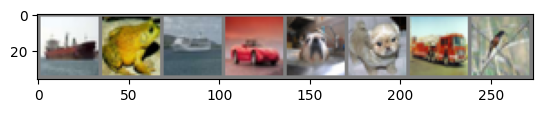

Actual:  ship          Predicted:  ship 
Actual:  frog          Predicted:  frog 
Actual:  ship          Predicted:  ship 
Actual:  automobile    Predicted:  automobile
Actual:  dog           Predicted:  dog  
Actual:  dog           Predicted:  dog  
Actual:  truck         Predicted:  truck
Actual:  bird          Predicted:  bird 


In [130]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

data_iter = iter(test_loader)
images, labels = next(data_iter)

# print images
imshow(torchvision.utils.make_grid(images))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

#outputting the actual and predicted classes of each image
for pred_img in range(8):
    print("Actual: ", ''.join(f'{classes[labels[pred_img]]:10s}'),        
          "   Predicted: ",''.join(f'{classes[predicted[pred_img]]:5s}'))



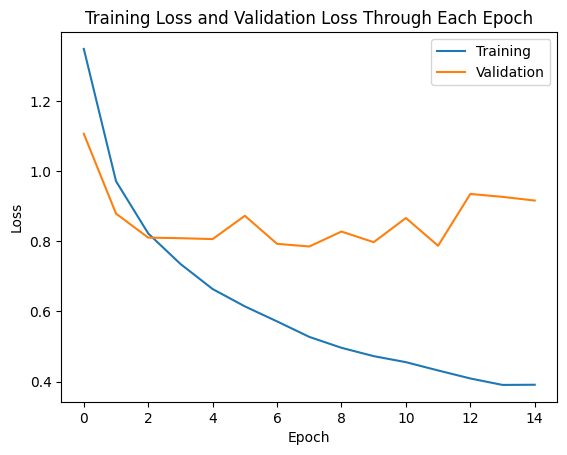

In [131]:
def plot_losses(results):
    """ Plot the losses in each epoch"""
    train_losses = []
    val_losses = []
    
    for epoch_vals in results:
        train_losses.append(epoch_vals.get('train_loss'))
        val_losses.append(epoch_vals['val_loss'])

    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Training Loss and Validation Loss Through Each Epoch');

plot_losses(history)

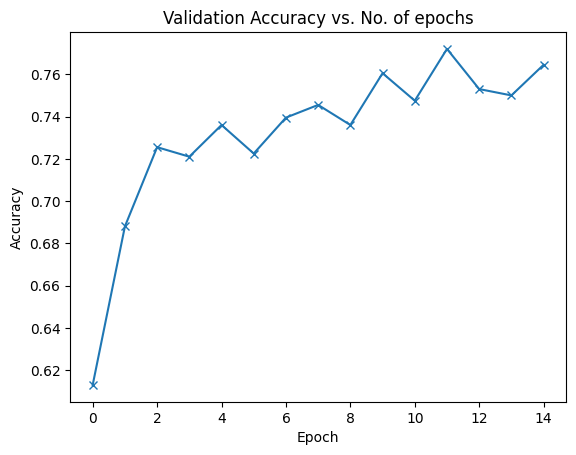

In [132]:
def plot_accuracies(results):
    accuracies = []
    for epoch_vals in results:
        accuracies.append(epoch_vals['val_acc'])

    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs. No. of epochs');

plot_accuracies(history)

Accuracy of the network on the 10000 test images: 75 %


<AxesSubplot:title={'center':'Heatmap of model accuracy'}>

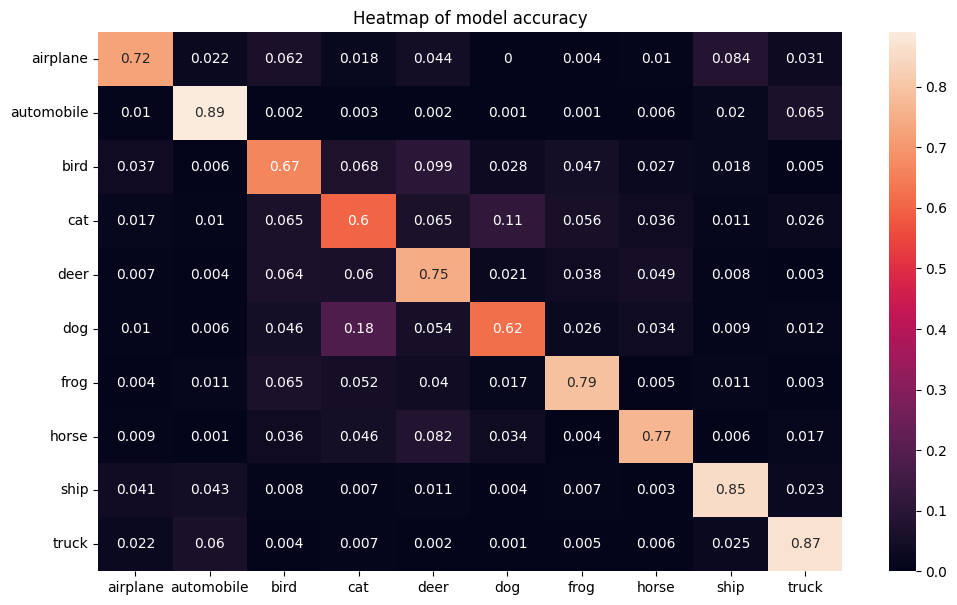

In [134]:
correct = 0
total = 0
y_pred = []
y_true = []


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        
        # calculate outputs by running images through the network
        outputs = net(images)
        outputs_heat = net(images)
        
        #counting the amount of images seen and the amount that is correct and iterating
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
        outputs_heat = (torch.max(torch.exp(outputs_heat), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs_heat) # predicted values
        
        labels_heat = labels.data.cpu().numpy()
        y_true.extend(labels_heat) # actual values

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


#setting a confusion matrix for a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title("Heatmap of model accuracy")
sns.heatmap(df_cm, annot=True)